In [58]:
import os
import scipy
import re

from mido import MidiFile
import networkx as nx
from networkx_viewer import Viewer
import matplotlib
import matplotlib.pyplot as plt

import math
import numpy as np
import pandas as pd

import datashader as ds
import datashader.transfer_functions as tf
from datashader.layout import random_layout, circular_layout, forceatlas2_layout
from datashader.bundling import connect_edges, hammer_bundle

from itertools import chain

print(scipy.__version__)
print(matplotlib.__version__)
print(nx.__version__)

1.10.0
3.5.1
2.8.7


In [3]:
mid = MidiFile("C:\\Users\\vamvp\Desktop\\Albert King - Born Under A Bad Sign.mid", clip=True)

In [13]:
for msg in mid.tracks[1]:
    print(msg)

program_change channel=14 program=30 time=0
control_change channel=14 control=121 value=0 time=8
control_change channel=14 control=0 value=0 time=0
control_change channel=14 control=32 value=0 time=0
note_on channel=14 note=68 velocity=127 time=7000
note_on channel=14 note=68 velocity=0 time=91
note_on channel=14 note=70 velocity=126 time=5
note_on channel=14 note=70 velocity=0 time=57
note_on channel=14 note=70 velocity=127 time=39
note_on channel=14 note=70 velocity=0 time=35
note_on channel=14 note=73 velocity=127 time=13
pitchwheel channel=14 pitch=130 time=76
pitchwheel channel=14 pitch=910 time=12
pitchwheel channel=14 pitch=1690 time=6
pitchwheel channel=14 pitch=2470 time=6
pitchwheel channel=14 pitch=3250 time=7
pitchwheel channel=14 pitch=3770 time=9
pitchwheel channel=14 pitch=2210 time=7
note_on channel=14 note=73 velocity=0 time=1
pitchwheel channel=14 pitch=0 time=0
note_on channel=14 note=70 velocity=127 time=20
note_on channel=14 note=70 velocity=0 time=393
note_on chan

In [22]:
G = nx.read_edgelist("./slac/embeddings/edgelist0/program_test.edgelist")
print("Network Loaded")


Network Loaded


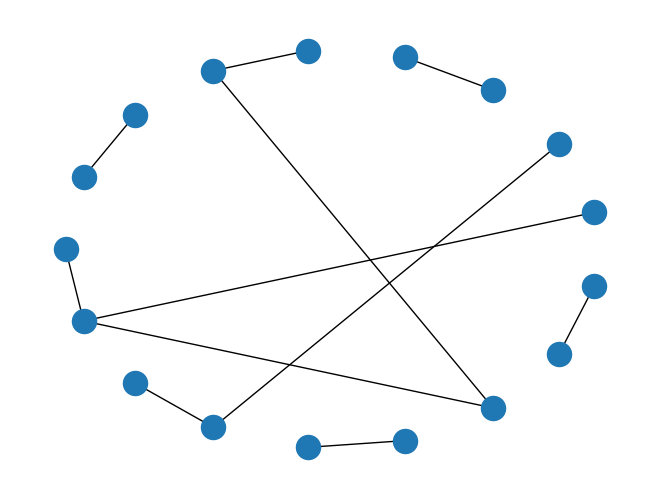

In [26]:
nx.draw_shell(G)

In [4]:
def complete_graph(input_path) -> nx.Graph:
    edgelists = [qf for qf in os.listdir(input_path)
                 if qf.endswith('.edgelist') and not qf.startswith('_')]
    g = None

    print('loading edgelists...')
    for eg in edgelists:
        print('- ' + eg)
        h = nx.read_edgelist(os.path.join(input_path, eg), nodetype=str, create_using=nx.DiGraph(), delimiter=' ')
        for edge in h.edges():
            h[edge[0]][edge[1]]['weight'] = 1

        g = h if g is None else nx.compose(g, h)

    g = g.to_undirected()

    print('Nodes: %d' % nx.number_of_nodes(g))
    print('Edges: %d' % nx.number_of_edges(g))
    return g


In [5]:
com_gr = complete_graph("C:\\Users\\vamvp\Desktop\Test Edgelists")

loading edgelists...
- full_edgelist.edgelist
- notes.edgelist
- program.edgelist
- tempo.edgelist
- time.signature.edgelist
Nodes: 2703
Edges: 19366


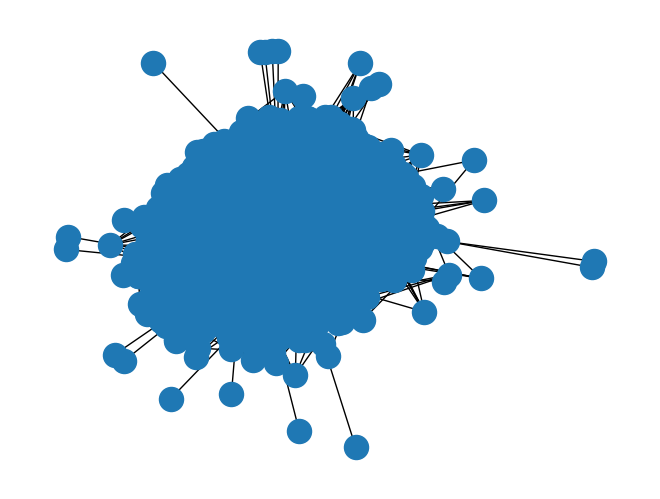

In [8]:
nx.draw(com_gr, )

In [10]:
nx.write_edgelist(com_gr, "C:\\Users\\vamvp\Desktop\Test Edgelists\\full_edgelist.edgelist")

In [45]:
nodes = pd.DataFrame((list(com_gr.nodes)), columns=['name'])
edges = pd.DataFrame(np.array(list(com_gr.edges)), columns=['source', 'target'])

In [51]:
# from https://datashader.org/user_guide/Networks.html

# forcedirected = forceatlas2_layout(nodes, edges)
circular  = circular_layout(nodes, uniform=False)

cvsopts = dict(plot_height=400, plot_width=400)

def nodesplot(nodes, name=None, canvas=None, cat=None):
    canvas = ds.Canvas(**cvsopts) if canvas is None else canvas
    aggregator=None if cat is None else ds.count_cat(cat)
    agg=canvas.points(nodes,'x','y',aggregator)
    return tf.spread(tf.shade(agg, cmap=["#FF3333"]), px=3, name=name)

def edgesplot(edges, name=None, canvas=None):
    canvas = ds.Canvas(**cvsopts) if canvas is None else canvas
    return tf.shade(canvas.line(edges, 'x','y', agg=ds.count()), name=name)

def graphplot(nodes, edges, name="", canvas=None, cat=None):
    if canvas is None:
        xr = nodes.x.min(), nodes.x.max()
        yr = nodes.y.min(), nodes.y.max()
        canvas = ds.Canvas(x_range=xr, y_range=yr, **cvsopts)

    np = nodesplot(nodes, name + " nodes", canvas, cat)
    ep = edgesplot(edges, name + " edges", canvas)
    return tf.stack(ep, np, how="over", name=name)

In [59]:
app = Viewer(com_gr)
app.mainloop()